# 9-6. 프로젝트 : 폐렴 진단기 성능개선

## Step 1. 실험환경 Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25
print(ROOT_PATH)

/aiffel/aiffel


# Step 2. 데이터 준비하기

### 1. DataSet 확인



In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train 데이터 5216개
test 데이터 624개
val 데이터 16개 
- val data가 부족

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


- train data에서 val data를 조금 옮겨주었다. 
- train data = 4185 , val data =1047

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


- 파일이름을 통해 training set안에 있는 정상과 폐렴의 사진의 갯수를 확인할 수 있다.
- 정상과 폐렴의 사진이 불균형하다. -> 정상적으로 학습이 안될 수 있기 때문에 개선필요

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

- tf.data는 Tensorflow에서 학습시킬 때 배치처리 작업을 더 효율적으로 하게 하는 객체이다.
- train과 val을 따로 생성

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


- train img, val img 갯수를 numpy int로 바꿔준다.

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

- get_label함수를 통해 이미지의 라벨을 맞춰준다. (이미지의 이름으로)
- decode_img함수를 통해 이미지를 tesor로 바꾼뒤 리사이즈를 하여 학습할 수 있는 형태로 바꿔준다.
- 저 두함수를 합쳐 process_path 함수에서 라벨을 검출하고 이미지를 읽은 뒤 이미지를 알맞은 형식으로 수정한다.

In [10]:
train_ds_base = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds_base = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

- base dataset를 만들었다.
- augmentation과 비교하기 만들기 때문에 base라고 명칭했다.

병렬 매핑을 통해 dataset을 만든다. 학습속도가 빠르다고 한다. ->https://www.tensorflow.org/guide/data_performance?hl=ko
``` 
benchmark(
    ArtificialDataset()
    .map(
        mapped_function,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
)
```
- 그림

![](https://www.tensorflow.org/guide/images/data_performance/parallel_map.svg?hl=ko)

In [11]:
for image, label in train_ds_base.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [12]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


- 데이터셋에서 하나를 가져온뒤 모양과 label을 확인
- 테스트셋에도 같은 과정을 거친다.

In [13]:
def prepare_for_training_1(ds, shuffle_buffer_size=1000,BATCH_SIZE=16):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_1 = prepare_for_training_1(train_ds_base,BATCH_SIZE=BATCH_SIZE)
val_ds_1 = prepare_for_training_1(val_ds_base,BATCH_SIZE=BATCH_SIZE)

- augment가 없는 기존 데이터셋
- prepare_for_training 함수는 학습효율을 높이기 위한 데이터 처리 함수
 - shuffle() 을 사용하면 고정 크기의 버퍼를 유지한 채, 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택하게 된다.
 - repeat() 를 사용한 데이터셋은 해당 데이터셋을 여러 번 사용할 수 있게 해주고, 자동으로 데이터를 맞춰주기도 한다. 예를 들어 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 된다.
 - batch() 는 하이퍼파라미터였던 BATCH_SIZE에서 정한 만큼의 배치를 부여한다. 예를 들어 100개의 데이터를 10개의 배치로 나눈다면 한 배치당 10개의 데이터로 나뉜다.
 - prefetch() 는 학습 데이터를 나눠서 읽어오도록 하는 함수로, 리소스의 유휴 상태를 줄여 효율을 높일 수 있다.

In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training_2(ds, shuffle_buffer_size=1000,BATCH_SIZE=16):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_2 = prepare_for_training_2(train_ds_base,BATCH_SIZE)
val_ds_2 = prepare_for_training_2(val_ds_base,BATCH_SIZE)

- 좌우반전을 한 dataset

### X-ray를 찍을때 검출되는 노이즈 : 
X-ray 영상 시스템에서는, 크게 2 종류의 noise 성분이 함유되어있다. 먼저 x-ray 방사선이 조사되어질 때, 검출기에서의 방사선의 상호작용으로부터 발생되어지는 것으로서 랜덤하게 발생되어지는 **Poisson noise** 성분이다. 다음으로 noise 성분은 readout electronics noise, pixel pattern noise 그리고 off-set noise 등으로부터 발생되어지는 **Gaussian noise** 성분이다.
https://www.koreascience.or.kr/article/JAKO200704503665727.page

### 여기서 가우시안 성분의 노이즈를 채텍해 augement해보기로 했다.

### Augement :
- 좌우대칭
- 노이즈 입히기 :
X-ray 이미지에는 Poisson noise 성분과 Gaussian noise 성분이 있다. 
우리가 학습할 이미지에서 실제로 이 노이즈가 있는지 없는지는 잘 모르겠지만 실제로 저런 성분의 노이즈가 검출 됨으로, 아주 조금 노이즈를 입혀 augment을 하겠다. 하지만 augmentation 기법을 고려해 볼 수 있을 것입니다. 
- 두가지의 데이터셋 :
의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없다. 
특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문 그래서 데이터 셋을 두개로 나누겠다.

In [15]:
import cv2
import random
def noise_augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    noise_type=random.randint(0,3)
    if 0 == 0:  #가우시안
        print('a')
        row,col,ch= 180,180,3
        mean = 0
        var = 0.1
        sigma = var**0.99
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        image = image + gauss 
   
    return image,label

def prepare_for_training_3(ds, shuffle_buffer_size=1000,BATCH_SIZE=16):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            noise_augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_3 = prepare_for_training_3(train_ds_base,BATCH_SIZE)
val_ds_3 = prepare_for_training_3(val_ds_base,BATCH_SIZE)


a
a


In [16]:
print(train_ds_3)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다. tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.

shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.





## Step 3. 데이터 시각화
##### 1. base 
##### 2. 좌우반전
##### 3. 가우시안 노이즈+ 좌우반전

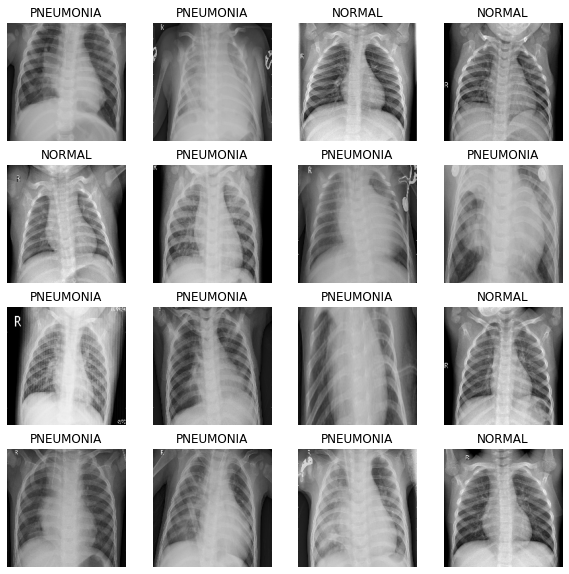

In [17]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds_1))
show_batch(image_batch.numpy(), label_batch.numpy())

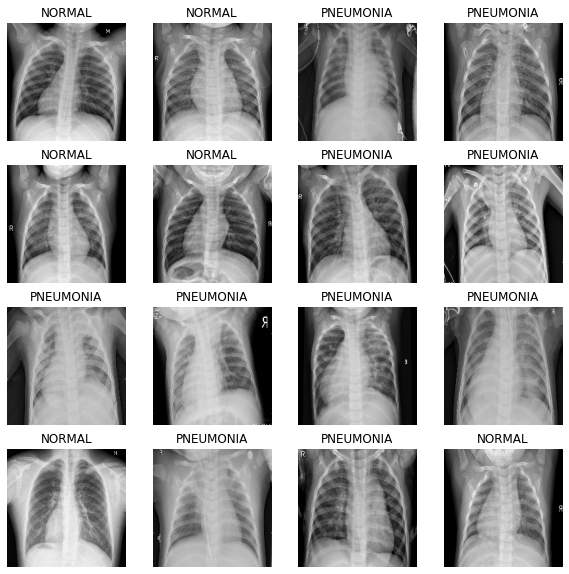

In [18]:
image_batch, label_batch = next(iter(train_ds_2))
show_batch(image_batch.numpy(), label_batch.numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

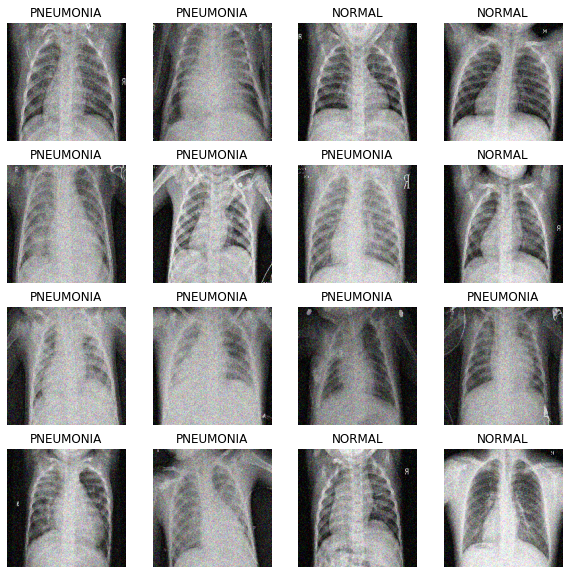

In [19]:
image_batch, label_batch = next(iter(train_ds_3))
show_batch(image_batch.numpy(), label_batch.numpy())

- 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치빼서 배치를 image와 label 데이터 셋으로 나눈다.
- 3가지 augmentation을 볼 수 있다.

## Step 4. CNN 모델링
- 실습에서 와 똑같은 모델링
- 학습을 해본뒤 조금씩 변경해볼 예정

In [20]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

- conv_block()의 구성 : Convolution을 두 번 진행  + Batch Normalization 
- Batch Normalization을 통해 Gradient vanishing, Gradient Exploding을 해결. 그리고 Max Pooling을 한다.

In [21]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

- Dense_block에서는 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있습니다.
- 일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 합니다.

In [22]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리


정상과 폐렴 데이터차이는 3000천개 정도된다.

이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다. Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있다.


아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅합니다. 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.

In [23]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다.
성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

# step 6. 훈련 및 평가
## 바닐라
- batch =16
- epochs = 25
- 이미지 = no augmentation

In [24]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [25]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_1,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_1,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 84s 191ms/step - loss: 0.4342 - accuracy: 0.7742 - precision: 0.9384 - recall: 0.7455 - val_loss: 0.6592 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2249 - accuracy: 0.9136 - precision: 0.9748 - recall: 0.9074 - val_loss: 1.3118 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2220 - accuracy: 0.9181 - precision: 0.9736 - recall: 0.9146 - val_loss: 0.1324 - val_accuracy: 0.9442 - val_precision: 0.9304 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1824 - accuracy: 0.9313 - precision: 0.9774 - recall: 0.9294 - val_loss: 0.1737 - val_accuracy: 0.9433 - val_precision: 0.9958 - val_recall: 0.9266
Epoch 5/25
261/261 [==============================] - 51s 194ms/step - loss: 0.1746 - accura

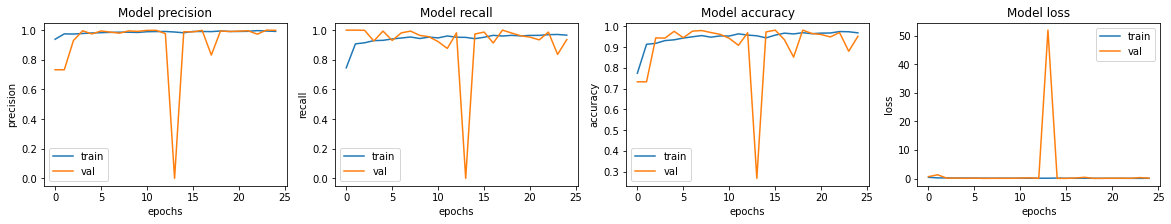

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 106ms/step - loss: 0.6570 - accuracy: 0.8558 - precision: 0.8348 - recall: 0.9590
Loss: 0.6569620966911316,
Accuracy: 0.8557692170143127,
Precision: 0.8348214030265808,
Recall: 0.9589743614196777


- epochs가 10~15사이에서 precision이 확 떨어진 경향이 있다. 
- 나중에 10으로 바꿔보겠다.
- recall = 95%, Accuracy:85% << 목표도달

## Augment1 (이미지 좌우 랜덤변경)
- batch =16
- epochs = 25


In [28]:
with tf.device('/GPU:0'):
    model_aug_1 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_aug_1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )


In [29]:
with tf.device('/GPU:0'):
    history_2 = model_aug_1.fit(
        train_ds_2,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_2,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 42s 152ms/step - loss: 0.4259 - accuracy: 0.7878 - precision: 0.9487 - recall: 0.7559 - val_loss: 0.6174 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 40s 153ms/step - loss: 0.2614 - accuracy: 0.8992 - precision: 0.9726 - recall: 0.8896 - val_loss: 0.8571 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 40s 152ms/step - loss: 0.2108 - accuracy: 0.9159 - precision: 0.9735 - recall: 0.9118 - val_loss: 0.1172 - val_accuracy: 0.9596 - val_precision: 0.9918 - val_recall: 0.9528
Epoch 4/25
261/261 [==============================] - 41s 156ms/step - loss: 0.2008 - accuracy: 0.9267 - precision: 0.9775 - recall: 0.9228 - val_loss: 0.1551 - val_accuracy: 0.9269 - val_precision: 0.9093 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 41s 158ms/step - loss: 0.1823 - accura

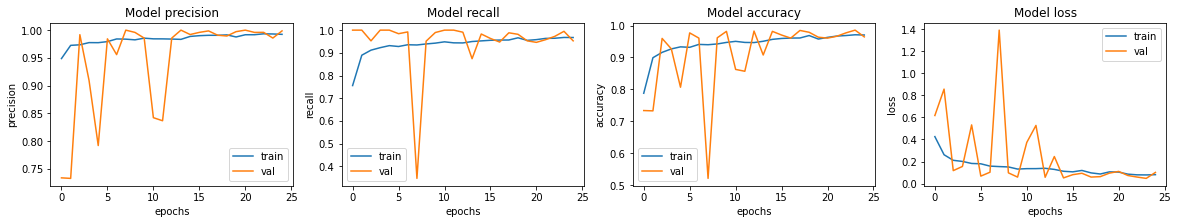

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_2.history[met])
    ax[i].plot(history_2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [31]:
loss, accuracy, precision, recall = model_aug_1.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 110ms/step - loss: 0.6271 - accuracy: 0.8429 - precision: 0.8120 - recall: 0.9744
Loss: 0.6270937919616699,
Accuracy: 0.8429487347602844,
Precision: 0.811965823173523,
Recall: 0.9743589758872986


- Recall: 0.97 Accuracy: 0.84

## Augment2( 가우시안 노이즈 추가)
- batch =16
- epochs = 25

In [33]:
with tf.device('/GPU:0'):
    model_aug_2 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_aug_2 .compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
with tf.device('/GPU:0'):
    history_3 = model_aug_2 .fit(
        train_ds_3,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_3,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 42s 154ms/step - loss: 0.4324 - accuracy: 0.7859 - precision: 0.9410 - recall: 0.7600 - val_loss: 0.6773 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 39s 151ms/step - loss: 0.2763 - accuracy: 0.8896 - precision: 0.9656 - recall: 0.8833 - val_loss: 1.4185 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 40s 153ms/step - loss: 0.2196 - accuracy: 0.9150 - precision: 0.9745 - recall: 0.9095 - val_loss: 0.4065 - val_accuracy: 0.8183 - val_precision: 0.8017 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 40s 154ms/step - loss: 0.2078 - accuracy: 0.9191 - precision: 0.9769 - recall: 0.9128 - val_loss: 0.2305 - val_accuracy: 0.9163 - val_precision: 0.9971 - val_recall: 0.8886
Epoch 5/25
261/261 [==============================] - 41s 157ms/step - loss: 0.1813 - accura

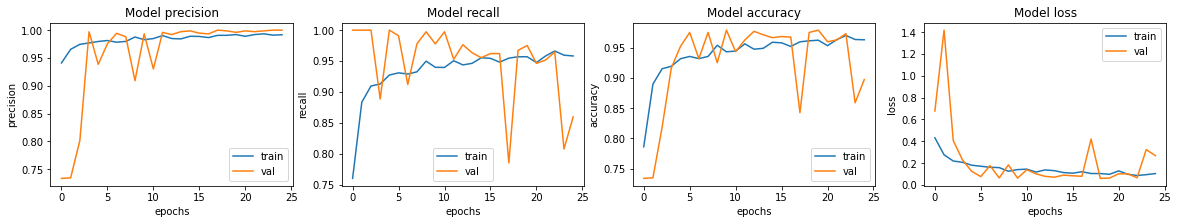

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_3.history[met])
    ax[i].plot(history_3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [35]:
loss, accuracy, precision, recall = model_aug_2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 0.5208 - accuracy: 0.8285 - precision: 0.8314 - recall: 0.9103
Loss: 0.5207564234733582,
Accuracy: 0.8285256624221802,
Precision: 0.8313817381858826,
Recall: 0.9102563858032227


- recall = 91%, Accuracy:82% 

### Augment하지 않은 것이 가장 좋아 augmentation하지 않는 방향으로 모델을 변경해보겠다.
## 바닐라(배치사이즈 변경)
- batch =64

In [37]:
train_ds_4 = prepare_for_training_1(train_ds_base,BATCH_SIZE=BATCH_SIZE)
val_ds_4 = prepare_for_training_1(train_ds_base,BATCH_SIZE=BATCH_SIZE)

In [38]:
with tf.device('/GPU:0'):
    model_base_2 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_base_2 .compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history_4 = model_base_2.fit(
        train_ds_4,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_4,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
65/65 [==============================] - 56s 705ms/step - loss: 0.4607 - accuracy: 0.7724 - precision: 0.9528 - recall: 0.7303 - val_loss: 0.5675 - val_accuracy: 0.7568 - val_precision: 0.7568 - val_recall: 1.0000
Epoch 2/25
65/65 [==============================] - 45s 698ms/step - loss: 0.2033 - accuracy: 0.9226 - precision: 0.9829 - recall: 0.9118 - val_loss: 0.6587 - val_accuracy: 0.7451 - val_precision: 0.7451 - val_recall: 1.0000
Epoch 3/25
65/65 [==============================] - 46s 710ms/step - loss: 0.1663 - accuracy: 0.9358 - precision: 0.9830 - recall: 0.9301 - val_loss: 0.7905 - val_accuracy: 0.7529 - val_precision: 0.7529 - val_recall: 1.0000
Epoch 4/25
65/65 [==============================] - 47s 726ms/step - loss: 0.1529 - accuracy: 0.9452 - precision: 0.9821 - recall: 0.9434 - val_loss: 0.8956 - val_accuracy: 0.7461 - val_precision: 0.7461 - val_recall: 1.0000
Epoch 5/25
65/65 [==============================] - 50s 776ms/step - loss: 0.1117 - accuracy: 0.9577

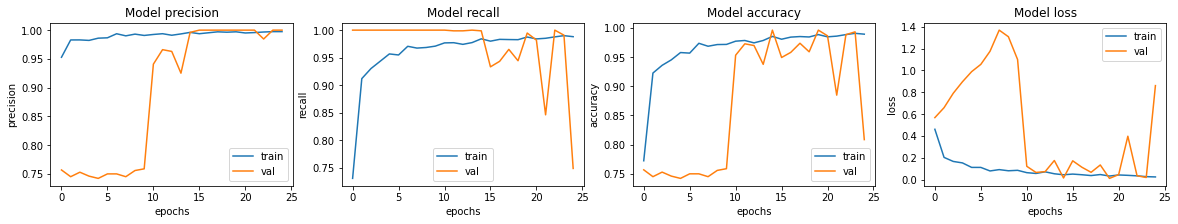

In [39]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_4.history[met])
    ax[i].plot(history_4.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [40]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)


In [41]:
loss, accuracy, precision, recall = model_base_2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 4s 438ms/step - loss: 0.7305 - accuracy: 0.8446 - precision: 0.9058 - recall: 0.8385
Loss: 0.7304991483688354,
Accuracy: 0.8445512652397156,
Precision: 0.9058171510696411,
Recall: 0.8384615182876587


- Accuracy: 0.8445512652397156, Recall: 0.8384615182876587

## 바닐라(Batch Size 변경 2)

- batchsize를 64로 하니 16보다 좋지 않아 32로 변경

In [42]:
BATCH_SIZE=32
train_ds_5 = prepare_for_training_1(train_ds_base,BATCH_SIZE=BATCH_SIZE)
val_ds_5 = prepare_for_training_1(train_ds_base,BATCH_SIZE=BATCH_SIZE)
with tf.device('/GPU:0'):
    model_base_3 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_base_3 .compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history_5 = model_base_3.fit(
        train_ds_5,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_5,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 56s 358ms/step - loss: 0.3926 - accuracy: 0.8067 - precision: 0.9523 - recall: 0.7795 - val_loss: 0.5983 - val_accuracy: 0.7529 - val_precision: 0.7529 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 46s 353ms/step - loss: 0.2101 - accuracy: 0.9219 - precision: 0.9744 - recall: 0.9193 - val_loss: 0.8117 - val_accuracy: 0.7607 - val_precision: 0.7607 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 46s 354ms/step - loss: 0.1648 - accuracy: 0.9382 - precision: 0.9762 - recall: 0.9399 - val_loss: 1.0737 - val_accuracy: 0.7432 - val_precision: 0.7432 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 47s 364ms/step - loss: 0.1501 - accuracy: 0.9483 - precision: 0.9826 - recall: 0.9473 - val_loss: 1.4011 - val_accuracy: 0.7529 - val_precision: 0.7529 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 48s 371ms/step - loss: 0.1361 - accura

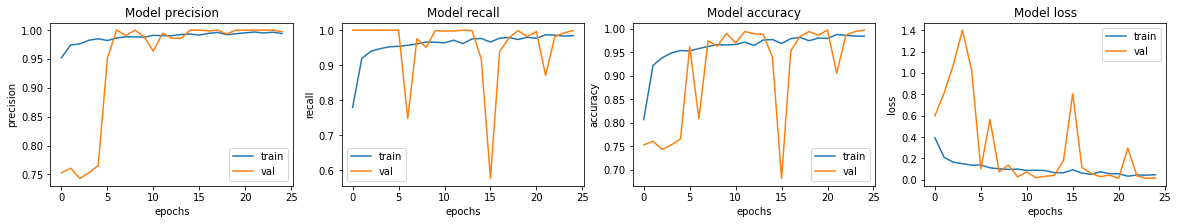

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_5.history[met])
    ax[i].plot(history_5.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [44]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [45]:
loss, accuracy, precision, recall = model_base_3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 194ms/step - loss: 1.1190 - accuracy: 0.7676 - precision: 0.7333 - recall: 0.9872
Loss: 1.118985891342163,
Accuracy: 0.7676281929016113,
Precision: 0.7333333492279053,
Recall: 0.9871794581413269


- Accuracy: 0.7676281929016113, Precision: 0.7333333492279053,

## 바닐라 (Drop_out 삭제)
- batch size는 16일때 가장 좋았다.
- dense block에서 배치정규화와 드랍아웃 둘다 쓰였기 때문에 한번 드랍아웃을 빼보겠다.
- batch size =16
- epochs = 25

In [47]:
def dense_block_2(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
    ])
    
    return block

In [48]:
def build_model_without_dropout():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_2(512),
        dense_block_2(128),
        dense_block_2(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [49]:
BATCH_SIZE=16

with tf.device('/GPU:0'):
    model_without_dropout = build_model_without_dropout()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_base_4 .compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history_6 = mmodel_without_dropout.fit(
        train_ds_1,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_1,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 55s 180ms/step - loss: 0.2465 - accuracy: 0.8992 - precision: 0.9719 - recall: 0.8903 - val_loss: 0.6969 - val_accuracy: 0.7538 - val_precision: 0.7538 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 47s 179ms/step - loss: 0.1793 - accuracy: 0.9274 - precision: 0.9785 - recall: 0.9228 - val_loss: 1.1366 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 48s 182ms/step - loss: 0.1250 - accuracy: 0.9540 - precision: 0.9867 - recall: 0.9511 - val_loss: 0.3079 - val_accuracy: 0.8471 - val_precision: 0.8326 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 47s 181ms/step - loss: 0.1246 - accuracy: 0.9521 - precision: 0.9856 - recall: 0.9494 - val_loss: 0.1246 - val_accuracy: 0.9587 - val_precision: 0.9972 - val_recall: 0.9463
Epoch 5/25
261/261 [==============================] - 48s 183ms/step - loss: 0.1287 - accura

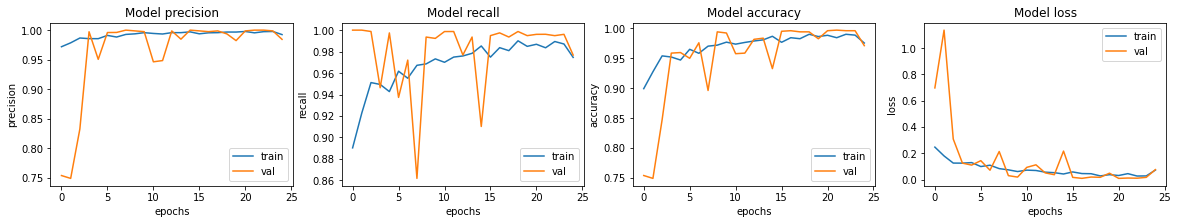

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_6.history[met])
    ax[i].plot(history_6.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [51]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
loss, accuracy, precision, recall = model_base_4.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 2.7137 - accuracy: 0.7853 - precision: 0.7490 - recall: 0.9872
Loss: 2.7137324810028076,
Accuracy: 0.7852563858032227,
Precision: 0.7490272521972656,
Recall: 0.9871794581413269


- Accuracy: 0.7852563858032227, Recall: 0.9871794581413269
- 정확도는 낮지만 Recall은 높다. 

## 바닐라 (drop_out rate 변경)

- densblock의 dropout rate 변경
- batch size =16
- epochs= 25

dense_block(512, 0.5),dense_block(128, 0.4), dense_block(64, 0.2)


In [54]:
def build_model_drop_rate():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.5),
        dense_block(128, 0.4),
        dense_block(64, 0.2),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model
BATCH_SIZE=16

with tf.device('/GPU:0'):
    model_ch_dropout_1 = build_model_drop_rate()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_ch_dropout_1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history_7 = model_ch_dropout_1.fit(
        train_ds_1,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_1,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 58s 187ms/step - loss: 0.3577 - accuracy: 0.8254 - precision: 0.9559 - recall: 0.8024 - val_loss: 0.7056 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 47s 181ms/step - loss: 0.2343 - accuracy: 0.9083 - precision: 0.9690 - recall: 0.9057 - val_loss: 1.3373 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 48s 184ms/step - loss: 0.1775 - accuracy: 0.9330 - precision: 0.9803 - recall: 0.9286 - val_loss: 1.4812 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 48s 183ms/step - loss: 0.1637 - accuracy: 0.9406 - precision: 0.9799 - recall: 0.9395 - val_loss: 0.0997 - val_accuracy: 0.9712 - val_precision: 0.9656 - val_recall: 0.9961
Epoch 5/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1552 - accura

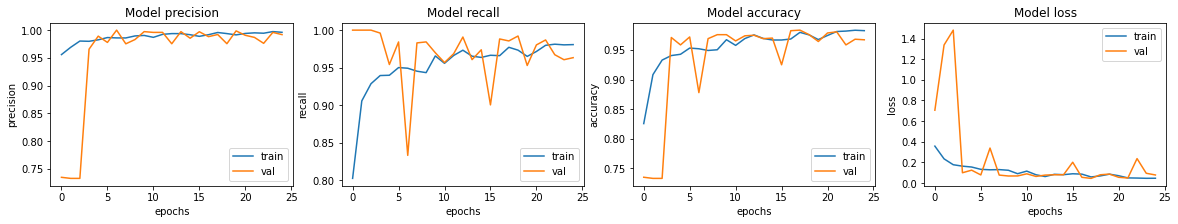

In [55]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_7.history[met])
    ax[i].plot(history_7.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [66]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
loss, accuracy, precision, recall = model_ch_dropout_1.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 1.1987 - accuracy: 0.7756 - precision: 0.7422 - recall: 0.9821
Loss: 1.1987106800079346,
Accuracy: 0.7756410241127014,
Precision: 0.7422480583190918,
Recall: 0.9820512533187866


- Accuracy: 0.7852563858032227, Recall: 0.9871794581413269
- dropout 비율을 바꿔도 Acc는 바닐라보다 낮다. 그래도 없는것보단 낫다.
- recall은 이번에도 높다.

## 바닐라(epochs=10)
- 바닐라 학습과정중 epoch가 10이후에 순간적으로 val이 낮아지는 것을 확인했다  => epochs 10으로 변경해보기


In [61]:
with tf.device('/GPU:0'):
    model_2 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history_8 = model_2.fit(
        train_ds_1,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=10,
        validation_data=val_ds_1,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 58s 189ms/step - loss: 0.3807 - accuracy: 0.8149 - precision: 0.9545 - recall: 0.7889 - val_loss: 0.7397 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 47s 182ms/step - loss: 0.2227 - accuracy: 0.9169 - precision: 0.9736 - recall: 0.9133 - val_loss: 1.1974 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 48s 183ms/step - loss: 0.2012 - accuracy: 0.9260 - precision: 0.9775 - recall: 0.9217 - val_loss: 0.6898 - val_accuracy: 0.7404 - val_precision: 0.7386 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 48s 185ms/step - loss: 0.1933 - accuracy: 0.9267 - precision: 0.9785 - recall: 0.9219 - val_loss: 0.1394 - val_accuracy: 0.9529 - val_precision: 0.9945 - val_recall: 0.9410
Epoch 5/10
261/261 [==============================] - 49s 188ms/step - loss: 0.1620 - accura

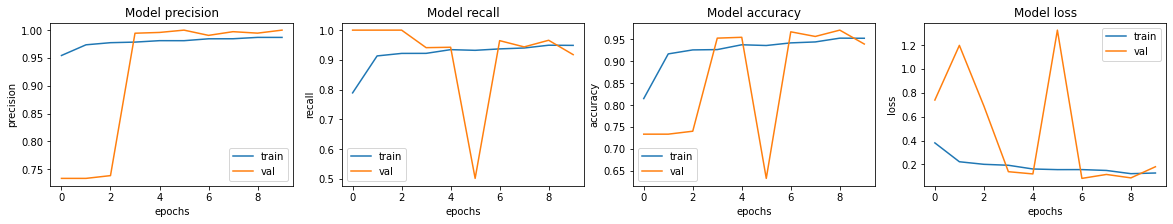

In [62]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_8.history[met])
    ax[i].plot(history_8.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [64]:
loss, accuracy, precision, recall = model_2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 104ms/step - loss: 0.5071 - accuracy: 0.8285 - precision: 0.8096 - recall: 0.9487
Loss: 0.5071235299110413,
Accuracy: 0.8285256624221802,
Precision: 0.8096280097961426,
Recall: 0.9487179517745972


- Accuracy: 0.8285256624221802, Recall: 0.9487179517745972
- 바닐라보다 정확도가 낮다. 아마 학습과정중에 가중치가 튕겨나간듯하다.

In [68]:
with tf.device('/GPU:0'):
    model_3 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history_9 = model_3.fit(
        train_ds_1,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=30,
        validation_data=val_ds_1,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
261/261 [==============================] - 57s 191ms/step - loss: 0.3960 - accuracy: 0.8082 - precision: 0.9576 - recall: 0.7770 - val_loss: 0.6246 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - 48s 185ms/step - loss: 0.2339 - accuracy: 0.9047 - precision: 0.9737 - recall: 0.8959 - val_loss: 1.0434 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/30
261/261 [==============================] - 49s 188ms/step - loss: 0.2076 - accuracy: 0.9207 - precision: 0.9744 - recall: 0.9178 - val_loss: 0.1804 - val_accuracy: 0.9087 - val_precision: 0.8914 - val_recall: 0.9974
Epoch 4/30
261/261 [==============================] - 49s 189ms/step - loss: 0.1936 - accuracy: 0.9248 - precision: 0.9784 - recall: 0.9192 - val_loss: 0.1018 - val_accuracy: 0.9654 - val_precision: 0.9619 - val_recall: 0.9921
Epoch 5/30
261/261 [==============================] - 50s 191ms/step - loss: 0.1585 - accura

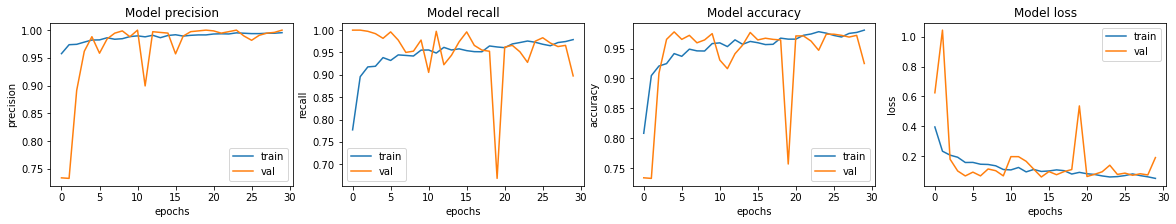

In [70]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_9.history[met])
    ax[i].plot(history_9.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [71]:
loss, accuracy, precision, recall = model_3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 102ms/step - loss: 0.6716 - accuracy: 0.8638 - precision: 0.8474 - recall: 0.9538
Loss: 0.6715606451034546,
Accuracy: 0.8637820482254028,
Precision: 0.8473803997039795,
Recall: 0.9538461565971375


- Accuracy: 0.8637820482254028,Recall: 0.9538461565971375
- 기존 바닐라보다 정확도가 높다.
- 목표기준 달성!

# 회고
- num_parallel_calls=AUTOTUNE 병렬맵핑을 사용하는 방법을 통해 학습속도를 빠르게 해줄 수 있는 사실을 알았다.
- Augement 기법에 대해 많이 생각해보았다. 
     - 일단 현실세게에서의 사진을 생각해보았을때 X-ray사진은 양옆으로 치우칠 수가 없을것 같고, 이상하게 찍은 모양이 거의 없을거라고 판단하여 이미지의 치우침이나 이동에 관해선 augmentation하지 않았다.
     - x-ray 사진을 찍을때 발생하는 노이즈에 관해 생각해보았다. 실제 기계에 따라 노이즈를 캔슬링해주는 X-ray가 있는 반면 아닌 것도 존재하였다. 그래서 Data sample이 노이즈가 실제로 있는지 없는지는 모르겠지만 일단 x-ray를 찍을때 나오는 가우시안 노이즈를 입혀보았다. 
     - 지금 생각해보면 모든 이미지에 처리하지 말고 이것도 랜덤으로 취해줬어야했는데 그것때문에 model_aug_2가 정확도가 생각보다 훨씬 낮은것 같다. 다른 augemntation을 하는 방법이 있을지 고민하는 과정에서 재미있었다.

- CNN 모델링에서 drop out과 batch nomalization을 동시에 썼다. 이게 별로 좋지 않다는 연구결과도 있었지만 이번 exploration에서는 효과가 좋았다. 
- 드랍아웃 비율을 조정해보고, 드랍아웃을 없애도 보고 batch size를 바꿔도 보고 그랬지만 바닐라에서 epochs를 늘렸을때 정확도가 가장 많이 올랐다.

- epochs가 10 이후에 순간적으로 엄청나게 loss가 발생하여 이부분에서 문제가 있는 줄 알았지만 지금 생각해보면 경로를 이탈한것같다. 이후에 다시 loss가 줄어들며 정확도가 높아지는데 이것을 보고 epochs를 늘려봤다.

- 모델 자체의 dense나 cnn층을 늘려도 봐도 좋았을거같다.

